<a href="https://colab.research.google.com/github/Jakub-Svoboda/VDT-predictive-NN/blob/main/vdt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [118]:
import tensorflow as tf
import numpy as np
import csv
import os
import glob
import pandas as pd
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#Dataset

## Variables dataset


In [119]:
# Remove sample_data folder which is added to colab automatically
!rm -rf sample_data

# Merge dataset from 90-days files
if not os.path.exists("dataset/data_merged.csv"):
  os.chdir("dataset")

  extension = 'csv'
  all_filenames = [i for i in glob.glob('data*.{}'.format(extension))]
  all_filenames = sorted(all_filenames)

  # Combine all files in the list
  combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
  # Export to csv
  combined_csv.to_csv( "data_merged.csv", index=False, encoding='utf-8-sig')
  os.chdir("..")

df = pd.read_csv(os.path.join("dataset", "data_merged.csv"))

## Weather prediction dataset


In [120]:
# Merge dataset from 90-days files
if not os.path.exists("dataset/weather_merged.csv"):
  os.chdir("dataset")

  extension = 'csv'
  all_filenames = [i for i in glob.glob('Teplota_Srazky*.{}'.format(extension))]
  all_filenames = sorted(all_filenames)

  # Combine all files in the list
  combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
  # Export to csv
  combined_csv.to_csv( "weather_merged.csv", index=False, encoding='utf-8-sig')
  os.chdir("..")

# Load to dataframe
df2 = pd.read_csv(os.path.join("dataset", "weather_merged.csv"))
df2 = df2.filter(items=['Srazky', '_time'])

In [121]:
# Join the Variables dataset and Rain prediction dataset (left join)
df = df.join(df2.set_index('_time'), on='_time')

In [122]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225510 entries, 0 to 225509
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CHSK         225510 non-null  float64
 1   CHSK_qc      225510 non-null  int64  
 2   N_NO3        225510 non-null  float64
 3   N_NO3_qc     225510 non-null  int64  
 4   NL           225510 non-null  float64
 5   NL_qc        225510 non-null  int64  
 6   pH           225510 non-null  float64
 7   pH_qc        225510 non-null  int64  
 8   q            225510 non-null  float64
 9   q_qc         225510 non-null  int64  
 10  Teplota      225510 non-null  float64
 11  Teplota_qc   225510 non-null  int64  
 12  Toxicita     225510 non-null  float64
 13  Toxicita_qc  225510 non-null  int64  
 14  Vodivost     225510 non-null  int64  
 15  Vodivost_qc  225510 non-null  int64  
 16  _time        225510 non-null  object 
 17  Srazky       28760 non-null   float64
dtypes: float64(8), int64(9),

##Filtering

Show missing values and improper sampling

In [123]:
%%script false --no-raise-error

lastDate = datetime.datetime.strptime("2017-11-01T01:00:00Z", '%Y-%m-%dT%H:%M:%SZ')
problemsCount = 0

# Go through data line by line
for index, row in df.iterrows():
  # The gap between two data points should be 5 minutes (300 sec)
  date = datetime.datetime.strptime(row['_time'], '%Y-%m-%dT%H:%M:%SZ')
  delta = (date - lastDate).total_seconds()
  lastDate = date
  if delta != 300: # Sampling should be done at 5min intervals == 300 sec
    problemsCount+=1
    #print("Delta:", delta, "     \t\t at time",date)

print(f'Processed {df.shape[0]} lines, found a total of', problemsCount, "problematic values/gaps.")

In [124]:
# Keep only these columns
df = df.filter(items=['CHSK', 'N_NO3', 'NL', 'q', 'Srazky', 'pH', 'Teplota', '_time'])

# Some of the data is sampled with different time rate. Eg in 2019 there was a period where the sampling period was 4 minutes. 
# For this reason, we filter values which were not sampled at the 5min interval (their time stamp does not end with 05 or 00).
df = df[(df['_time'].str.endswith(('5:00Z', '0:00Z')))]

In [125]:
%%script false --no-raise-error
lastDate = datetime.datetime.strptime("2017-11-01T01:00:00Z", '%Y-%m-%dT%H:%M:%SZ')
problemsCount = 0

# Go through data line by line
for index, row in df.iterrows():
  # The gap between two data points should be 5 minutes (300 sec)
  date = datetime.datetime.strptime(row['_time'], '%Y-%m-%dT%H:%M:%SZ')
  delta = (date - lastDate).total_seconds()
  lastDate = date
  if(delta != 300):
    problemsCount+=1
    print("Delta:", delta, "     \t\t at time",date)

print(f'Processed {df.shape[0]} lines, found a total of', problemsCount, "problematic values/gaps.")
df.shape

 Add a column of unix time (int), which is derived from _time

In [126]:
df['unixTime'] = [int(datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=datetime.timezone.utc).timestamp()) for x in df['_time']]

times = df['unixTime']

df.to_csv( "filt.csv", index=False, encoding='utf-8-sig')
count = 0

df2 = pd.DataFrame(columns = ['CHSK', 'NL', 'N_NO3', 'q', 'Srazky', 'pH', 'Teplota', '_time', 'unixTime'])

for index, i in enumerate(range(1509498300, 1577836800+300, 300)):
  if i not in times.values:
    #print("Missing:", index, i)
    df2 = df2.append({'CHSK': None, 'NL': None, 'N_NO3': None, 'q': None, 'Srazky' : None, 'pH': None, 'Teplota': None, '_time': None, 'unixTime': i}, ignore_index = True)
    count += 1

print("Filled in a total of:", count, "missing data.")

# Append new values to the dataframe
df = df.append(df2, ignore_index = True)    

# Sort df
df = df.sort_values('unixTime')

Filled in a total of: 2499 missing data.


In [127]:
#df.to_csv("filt2.csv", encoding='utf-8-sig')
df.to_csv("filt2.csv", index=False, encoding='utf-8-sig')

Calculate new _time items for the filled in data. For each item in dataframe, if the _time is missing, fill in previous _time + 5 minutes.

In [128]:
df = pd.read_csv("filt2.csv")
#df.reindex()
df.reset_index()

# Fill in the _time values from previous entry
for index, row in df.iterrows():
  #print(index, df.at[index, '_time'])
  if pd.isnull(df['_time'].iloc[index]):
    #print(index-1, df.at[index-1, '_time'])
    newDate = datetime.datetime.strptime(df.at[index-1, '_time'], '%Y-%m-%dT%H:%M:%SZ') + datetime.timedelta(minutes=5)
    #print(newDate.strftime("%Y-%m-%dT%H:%M:%SZ"))
    df.at[index,'_time'] = newDate.strftime("%Y-%m-%dT%H:%M:%SZ")
    #print(index, df.at[index,'_time'])
    #print('------')
    
print("Inserted", count, "_time dates. DF shape:", df.shape)

Inserted 2499 _time dates. DF shape: (227796, 9)


Interpolate missing data with 3th order polynomial interpolation

In [129]:
df = df.interpolate(method='polynomial', order=3)
print(df.iloc[2417])

CHSK                     486.805
N_NO3                    1.12867
NL                       187.699
q                        2.80808
Srazky               2.65199e-08
pH                       7.92102
Teplota                  17.1796
_time       2017-11-09T10:30:00Z
unixTime             1.51022e+09
Name: 2417, dtype: object


Shift the rain by one day to simulate rain prediction

In [130]:
df['Srazky'] = df['Srazky'].shift(-288)

Pandas does not interpolate to the very edge of the dataframe, for these we fill in 0 to where the 'Srazky' column is NaN.

In [131]:
df['Srazky'] = df['Srazky'].fillna(0)

The interpolation method can estimate the values of rain to be a small negative value, we replace all negative values with zero.

In [132]:
df['Srazky'] = df['Srazky'].clip(lower=0)

##Dataset inspection

In [133]:
df.head()

,CHSK,N_NO3,NL,q,Srazky,pH,Teplota,_time,unixTime
0,520.51,0.68,226.69,1.871,0.0,7.1,18.8,2017-11-01T01:05:00Z,1.509498e+09
1,521.18,0.66,227.46,1.866,0.0,7.1,18.8,2017-11-01T01:10:00Z,1.509499e+09
2,520.74,0.67,227.10,1.845,0.0,7.2,18.8,2017-11-01T01:15:00Z,1.509499e+09
3,521.36,0.65,227.68,1.776,0.0,7.1,18.8,2017-11-01T01:20:00Z,1.509499e+09
4,520.89,0.65,227.60,1.800,0.0,7.2,18.9,2017-11-01T01:25:00Z,1.509500e+09


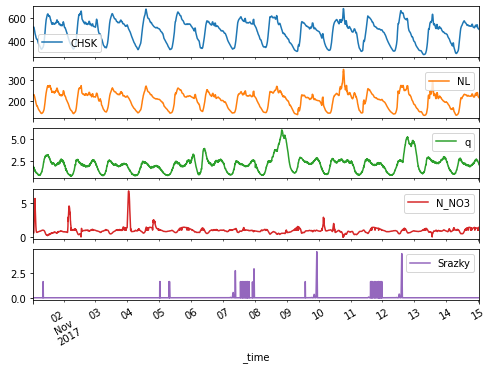

In [134]:
fiveMinsInWeek = 2016
date_time = pd.to_datetime(df['_time'], format='%Y-%m-%dT%H:%M:%SZ')
plot_cols = ['CHSK', 'NL', 'q', 'N_NO3', 'Srazky']
#plot_cols = ['CHSK', 'NL', 'q', 'N_NO3']

plot_features = df[plot_cols][0:fiveMinsInWeek*2]
plot_features.index = date_time.iloc[:fiveMinsInWeek*2]
_ = plot_features.plot(subplots=True)

In [135]:
df.describe().transpose()
# Teplota   max 1.271387e+02    = 127C
# N_NO3     min -1.828027e+00   = -1.8

,count,mean,std,min,25%,50%,75%,max
CHSK,227796.0,5.148296e+02,1.102134e+02,2.463800e+02,4.364100e+02,5.251800e+02,5.818300e+02,1.778800e+03
N_NO3,227796.0,1.665879e+00,6.615546e-01,-1.828027e+00,1.190000e+00,1.620000e+00,2.100000e+00,1.072049e+01
NL,227796.0,2.070380e+02,5.291201e+01,6.790266e+01,1.737800e+02,2.065800e+02,2.311900e+02,1.128390e+03
q,227796.0,1.998345e+00,1.025974e+00,6.380000e-01,1.452000e+00,2.015000e+00,2.307000e+00,2.628500e+01
Srazky,227796.0,3.563527e-02,5.741387e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.787800e-28,5.762601e+01
pH,227796.0,7.402966e+00,7.210242e-01,-2.222755e+01,7.100000e+00,7.400000e+00,7.700000e+00,1.240448e+01
Teplota,227796.0,1.786023e+01,3.333545e+00,0.000000e+00,1.590000e+01,1.770000e+01,1.970000e+01,1.271387e+02
unixTime,227796.0,1.543668e+09,1.972776e+07,1.509498e+09,1.526583e+09,1.543668e+09,1.560752e+09,1.577837e+09


# Feature Engineering


##Extra feature creation

Add columns representing the time of the day and the progression of the year.
These values are added as a spectrum.


In [136]:
secondsPerDay = 24*60*60
secondsPerYear = 365.2425*secondsPerDay 

# Get seconds from date
timestamp_s = date_time.map(datetime.datetime.timestamp)

# Add columns to the dataframe
df['Day Sin'] = np.sin(timestamp_s * (2 * np.pi / secondsPerDay))
df['Day Cos'] = np.cos(timestamp_s * (2 * np.pi / secondsPerDay))
df['Year Sin'] = np.sin(timestamp_s * (2 * np.pi / secondsPerYear))
df['Year Cos'] = np.cos(timestamp_s * (2 * np.pi / secondsPerYear))

Add a column representing the day of the week.

In [137]:
minsInWeek = 10080
df['Day of week sin'] = [np.sin((datetime.timedelta(days=datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').weekday(), hours=datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').hour, minutes=datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').minute).total_seconds() //60)*(2*np.pi/minsInWeek)) for x in df['_time']]
df['Day of week cos'] = [np.cos((datetime.timedelta(days=datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').weekday(), hours=datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').hour, minutes=datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ').minute).total_seconds() //60)*(2*np.pi/minsInWeek)) for x in df['_time']]

In [138]:
print(datetime.timedelta(days=datetime.datetime.strptime('2021-02-24T14:00:00Z', '%Y-%m-%dT%H:%M:%SZ').weekday(), hours=datetime.datetime.strptime('2021-02-24T14:00:00Z', '%Y-%m-%dT%H:%M:%SZ').hour, minutes=datetime.datetime.strptime('2021-02-24T14:00:00Z', '%Y-%m-%dT%H:%M:%SZ').minute).total_seconds() //60)

3720.0


In [139]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CHSK,227796.0,5.148296e+02,1.102134e+02,2.463800e+02,4.364100e+02,5.251800e+02,5.818300e+02,1.778800e+03
N_NO3,227796.0,1.665879e+00,6.615546e-01,-1.828027e+00,1.190000e+00,1.620000e+00,2.100000e+00,1.072049e+01
NL,227796.0,2.070380e+02,5.291201e+01,6.790266e+01,1.737800e+02,2.065800e+02,2.311900e+02,1.128390e+03
q,227796.0,1.998345e+00,1.025974e+00,6.380000e-01,1.452000e+00,2.015000e+00,2.307000e+00,2.628500e+01
Srazky,227796.0,3.563527e-02,5.741387e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.787800e-28,5.762601e+01
pH,227796.0,7.402966e+00,7.210242e-01,-2.222755e+01,7.100000e+00,7.400000e+00,7.700000e+00,1.240448e+01
Teplota,227796.0,1.786023e+01,3.333545e+00,0.000000e+00,1.590000e+01,1.770000e+01,1.970000e+01,1.271387e+02
unixTime,227796.0,1.543668e+09,1.972776e+07,1.509498e+09,1.526583e+09,1.543668e+09,1.560752e+09,1.577837e+09
Day Sin,227796.0,-7.424154e-06,7.071260e-01,-1.000000e+00,-7.071068e-01,-5.639925e-14,7.071068e-01,1.000000e+00
Day Cos,227796.0,-5.200216e-05,7.070907e-01,-1.000000e+00,-7.071068e-01,-5.789296e-14,7.071068e-01,1.000000e+00


In [140]:
# Remove the helper columns (unixtime, daytime, _time)
#df = df.filter(items=['CHSK', 'N_NO3', 'NL', 'pH', 'q', 'Teplota', 'Toxicita', 'Vodivost', 'Day Sin', 'Day Cos', 'Year Sin', 'Year Cos', 'Day of week sin', 'Day of week cos'])
df = df.filter(items=['CHSK', 'N_NO3', 'NL', 'q', 'Srazky', 'Day Sin', 'Day Cos', 'Year Sin', 'Year Cos', 'Day of week sin', 'Day of week cos'])
df.tail()

,CHSK,N_NO3,NL,q,Srazky,Day Sin,Day Cos,Year Sin,Year Cos,Day of week sin,Day of week cos
227791,844.36,0.00,413.77,1.553,0.0,-8.715574e-02,0.996195,-0.002389,0.999997,0.977626,-0.210350
227792,836.58,0.00,403.74,1.588,0.0,-6.540313e-02,0.997859,-0.002330,0.999997,0.976966,-0.213396
227793,827.98,0.19,399.68,1.576,0.0,-4.361939e-02,0.999048,-0.002270,0.999997,0.976296,-0.216440
227794,818.24,0.16,393.00,1.606,0.0,-2.181489e-02,0.999762,-0.002210,0.999998,0.975617,-0.219481
227795,807.11,0.19,385.32,1.539,0.0,-7.670342e-12,1.000000,-0.002150,0.999998,0.974928,-0.222521


Text(0.5, 1.0, 'Time of day signal')

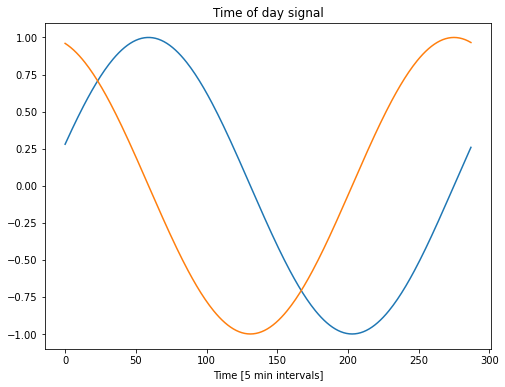

In [141]:
plt.plot(np.array(df['Day Sin'])[:12*24])
plt.plot(np.array(df['Day Cos'])[:12*24])
plt.xlabel('Time [5 min intervals]')
plt.title('Time of day signal')

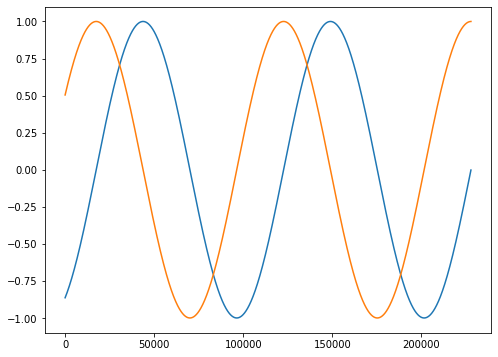

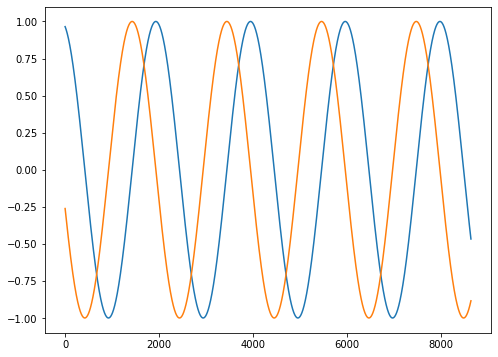

In [142]:
df['Year Sin'].T.plot()
df['Year Cos'].T.plot()
plt.show()

df['Day of week sin'].head(288*30).T.plot()
df['Day of week cos'].head(288*30).T.plot()
plt.show()

##Split


In [143]:
columnIndices = {name: i for i, name in enumerate(df.columns)}

# 80% train, 10% val, 10% test
n = len(df)
trainDf   = df[0:int(n*0.8)]
valDf     = df[int(n*0.8):int(n*0.9)]
testDf    = df[int(n*0.9):]

numFeatures = df.shape[1]
df.shape

(227796, 11)

In [144]:
x = np.sin(df['Year Sin'] * (2 * np.pi / secondsPerYear))
# Get seconds from date
timestamp_s = date_time.map(datetime.datetime.timestamp)

##Normalization

In [145]:
# Normalization = substraction of the mean and dividing by the standard deviation
trainMean = trainDf.mean()
trainStd = trainDf.std()

trainDf = (trainDf - trainMean) / trainStd
valDf = (valDf - trainMean) / trainStd
testDf = (testDf - trainMean) / trainStd

#Windowing

In [166]:
class WindowGenerator():
  def __init__(self, inputWidth, labelWidth, shift,
               trainDf=trainDf, valDf=valDf, testDf=testDf,
               labelColumns=None):
    # Store the raw data.
    self.trainDf = trainDf
    self.valDf = valDf
    self.testDf = testDf

    # Work out the label column indices.
    self.labelColumns = labelColumns
    if labelColumns is not None:
      self.labelColumnsIndices = {name: i for i, name in enumerate(labelColumns)}
    self.columnIndices = {name: i for i, name in enumerate(trainDf.columns)}

    # Work out the window parameters.
    self.inputWidth = inputWidth
    self.labelWidth = labelWidth
    self.shift = shift

    self.totalWindowSize = inputWidth + shift

    self.inputSlice = slice(0, inputWidth)
    self.inputIndices = np.arange(self.totalWindowSize)[self.inputSlice]

    self.labelStart = self.totalWindowSize - self.labelWidth
    self.labelsSlice = slice(self.labelStart, None)
    self.labelIndices = np.arange(self.totalWindowSize)[self.labelsSlice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.totalWindowSize}',
        f'Input indices: {self.inputIndices}',
        f'Label indices: {self.labelIndices}',
        f'Label column name(s): {self.labelColumns}'])
    
  # Splits window into a inputs and labels  
  def splitWindow(self, features):
    inputs = features[:, self.inputSlice, :]
    labels = features[:, self.labelsSlice, :]
    if self.labelColumns is not None:
      labels = tf.stack(
          [labels[:, :, self.columnIndices[name]] for name in self.labelColumns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.inputWidth, None])
    labels.set_shape([None, self.labelWidth, None])

    return inputs, labels 

  def plot(self, model=None, plotCol='CHSK', maxSubplots=4):
    inputs, labels = self.example
    plt.subplots(figsize=(18, 12))
    plotColIndex = self.columnIndices[plotCol]
    maxN = min(maxSubplots, len(inputs))
    for n in range(maxN):
      ax = plt.subplot(5, 1, n+1)
      plt.ylabel(f'{plotCol}')
      inputsTmp = (inputs * trainStd) + trainMean
      ax.plot(self.inputIndices, inputsTmp[n, :, plotColIndex], label='Inputs', marker='.', zorder=-10)
      #ax.plot(self.inputIndices, inputs[n, :, plotColIndex], label='Inputs', marker='.', zorder=-10)
      ax.set_ylim(ymin=0)

      if self.labelColumns:
        labelColIndex = self.labelColumnsIndices.get(plotCol, None)
      else:
        labelColIndex = plotColIndex

      if labelColIndex is None:
        continue

      stdTmp = trainStd.filter(items=['CHSK', 'N_NO3', 'NL', 'q'])
      meanTmp = trainMean.filter(items=['CHSK', 'N_NO3', 'NL', 'q'])
      labelsTmp = (labels * stdTmp) + meanTmp
      plt.plot(self.labelIndices, labelsTmp[n, :, labelColIndex], marker='.', label='Labels', c='#2ca02c')
      #plt.plot(self.labelIndices, labels[n, :, labelColIndex], marker='.', label='Labels', c='#2ca02c')
      if model is not None:
        predictions = model(inputs)
        predictions = (predictions * stdTmp) + meanTmp
        plt.plot(self.labelIndices, predictions[n, :, labelColIndex], marker='.', label='Predictions', c='#ff7f0e')

      if n == 0:
        plt.legend()

    

    plt.xlabel('Time [5min intervals]') 

  def makeDataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.totalWindowSize,
        sequence_stride=1,
        shuffle=True,
        batch_size=32*4,)
    
    ds.shuffle(5000000, reshuffle_each_iteration=True)

    ds = ds.map(self.splitWindow)
    return ds

  @property
  def train(self):
    return self.makeDataset(self.trainDf)

  @property
  def val(self):
    return self.makeDataset(self.valDf)

  @property
  def test(self):
    return self.makeDataset(self.testDf)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.test` dataset
      result = next(iter(self.test))
      # And cache it for next time
      self._example = result
    return result    

# NN Architectures



In [218]:
MAX_EPOCHS = 1

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate = 0.0015),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Total window size: 1440
Input indices: [   0    1    2 ... 1149 1150 1151]
Label indices: [1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165
 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179
 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193
 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207
 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221
 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235
 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249
 1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263
 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277
 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291
 1292 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305
 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319
 1320 1321 1322 1323 1324 1325 1326 1327 1328 1329 1330 13

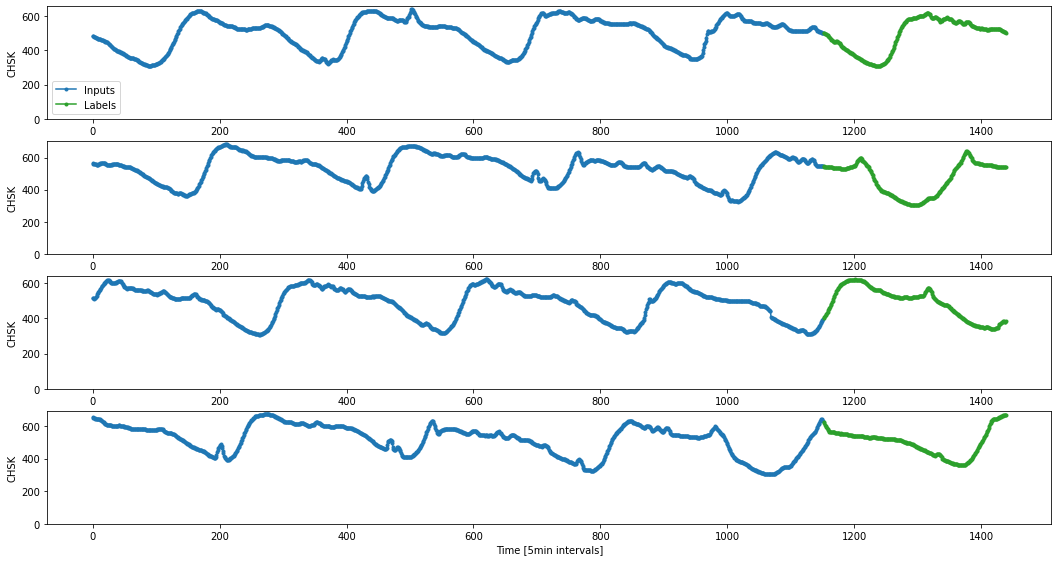

In [219]:
INPUT_DAYS = 4
OUTPUT_DAYS = 1

INPUT = 24*12*INPUT_DAYS
OUT_STEPS = 24*12*OUTPUT_DAYS

labelCols = ['CHSK', 'N_NO3', 'NL', 'q']

numOfOutFeatures = len(labelCols)

window = WindowGenerator(inputWidth=INPUT,
                               labelWidth=OUT_STEPS,
                               shift=OUT_STEPS,
                               labelColumns=labelCols)

window.plot()
window

##Baseline

In [220]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :numOfOutFeatures], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

print("Evaluating:")
val_performance['Baseline - Last'] = last_baseline.evaluate(window.val)
performance['Baseline - Last'] = last_baseline.evaluate(window.test, verbose=0)


Evaluating:
167/167 [==============================] - 3s 16ms/step - loss: 1.4398 - mean_absolute_error: 0.8121


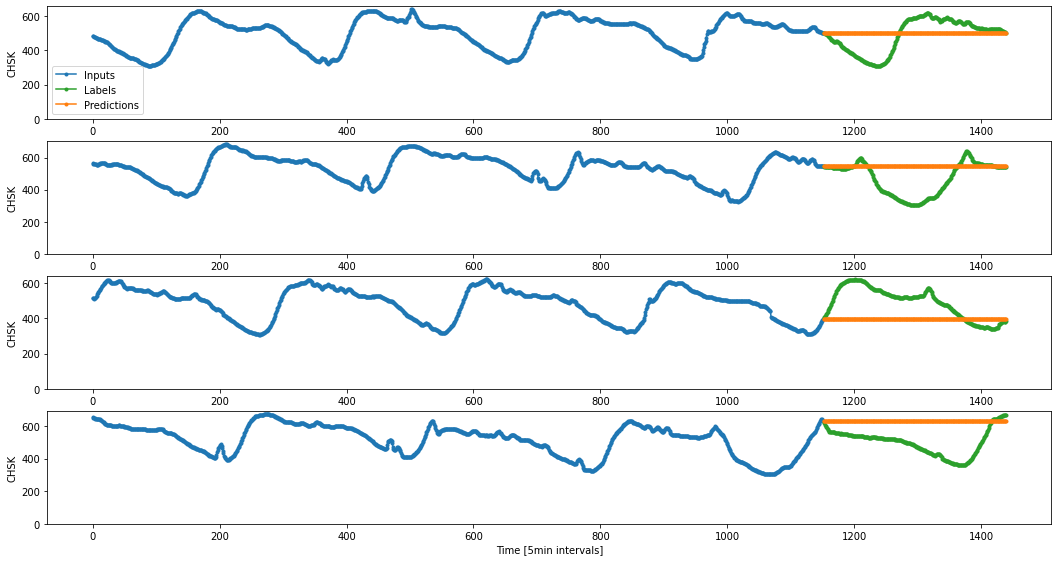

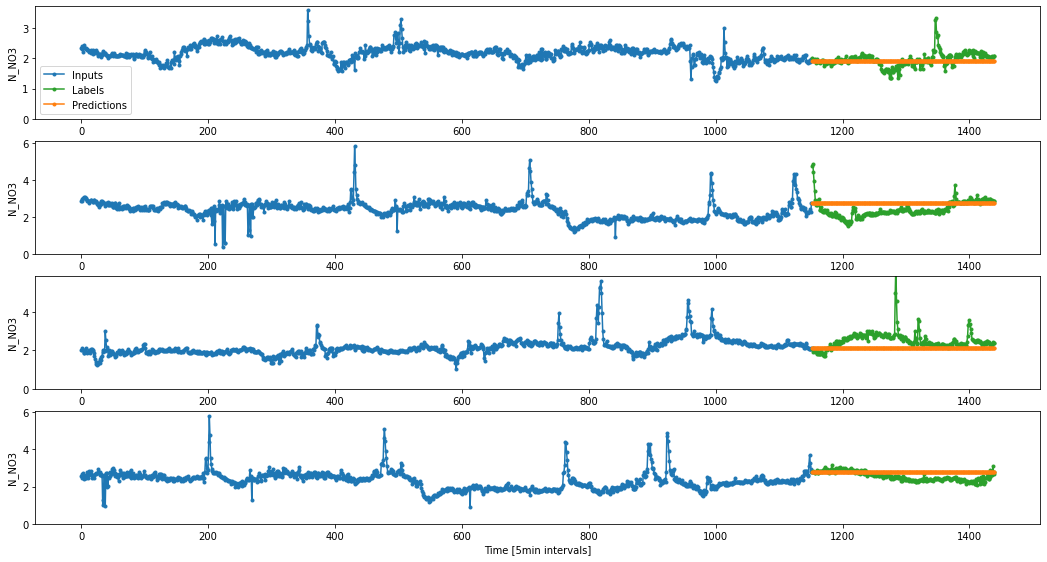

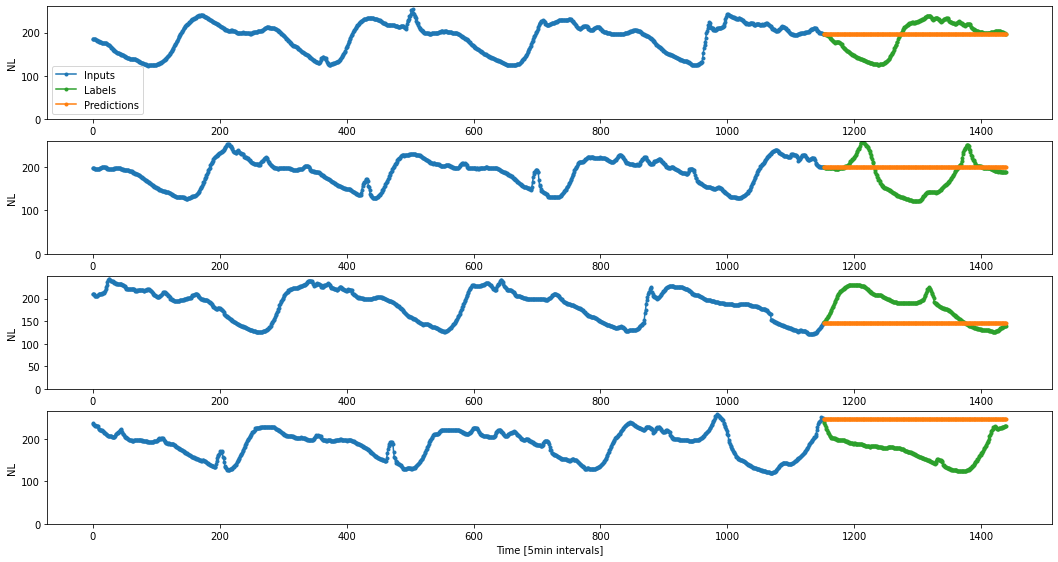

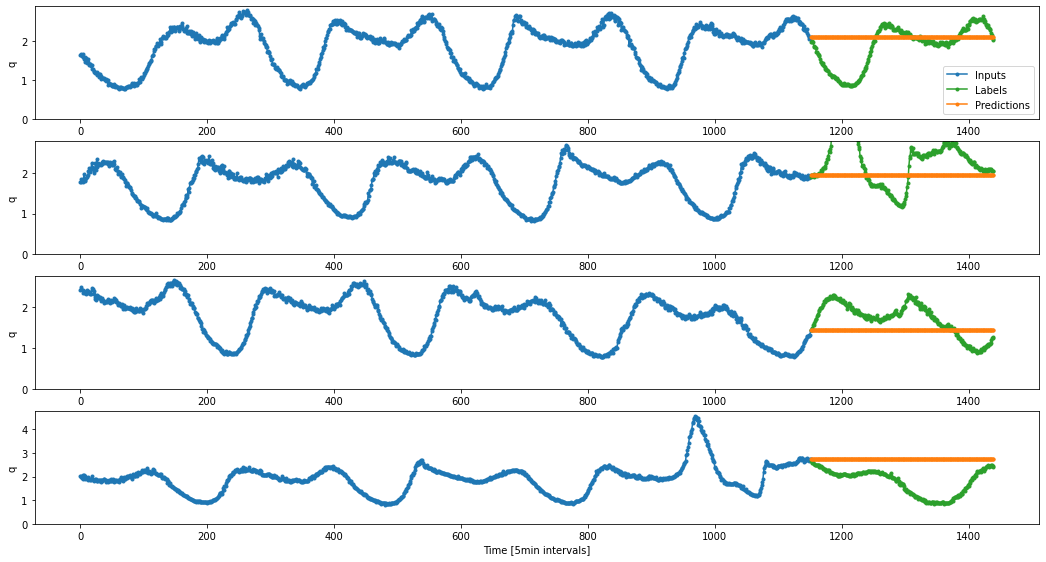

In [221]:
window.plot(last_baseline, plotCol='CHSK')
window.plot(last_baseline, plotCol='N_NO3')
window.plot(last_baseline, plotCol='NL')
window.plot(last_baseline, plotCol='q')

In [222]:
#%%script false --no-raise-error
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    #print(inputs.shape)
    #print(inputs[:, inputs.shape[1]-OUT_STEPS:, :numOfOutFeatures])
    return inputs[:, inputs.shape[1]-OUT_STEPS:, :numOfOutFeatures]

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = repeat_baseline.evaluate(window.val)
performance['Baseline - Repeat'] = repeat_baseline.evaluate(window.test, verbose=0)

167/167 [==============================] - 3s 16ms/step - loss: 1.0849 - mean_absolute_error: 0.5521


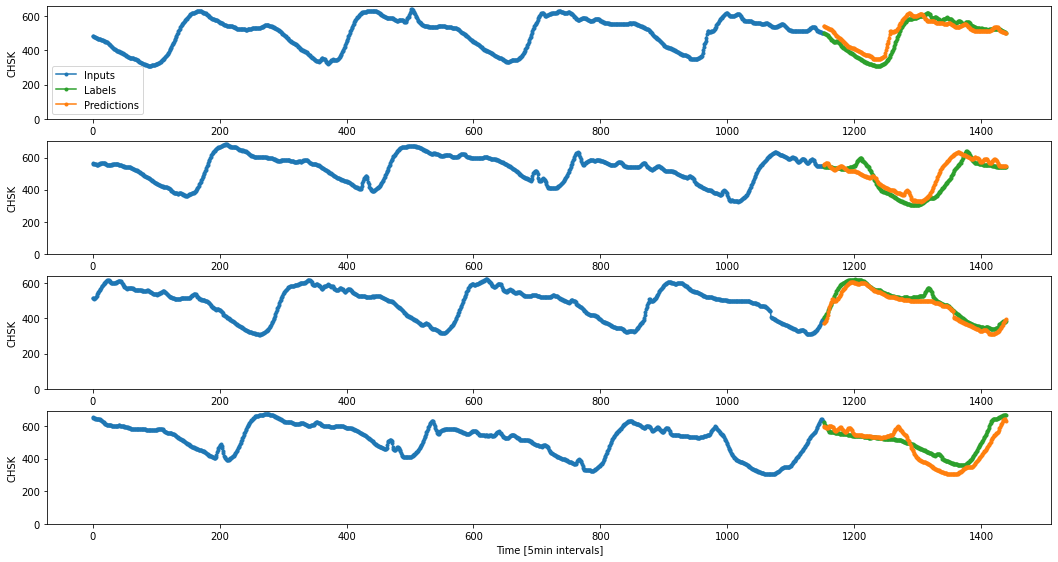

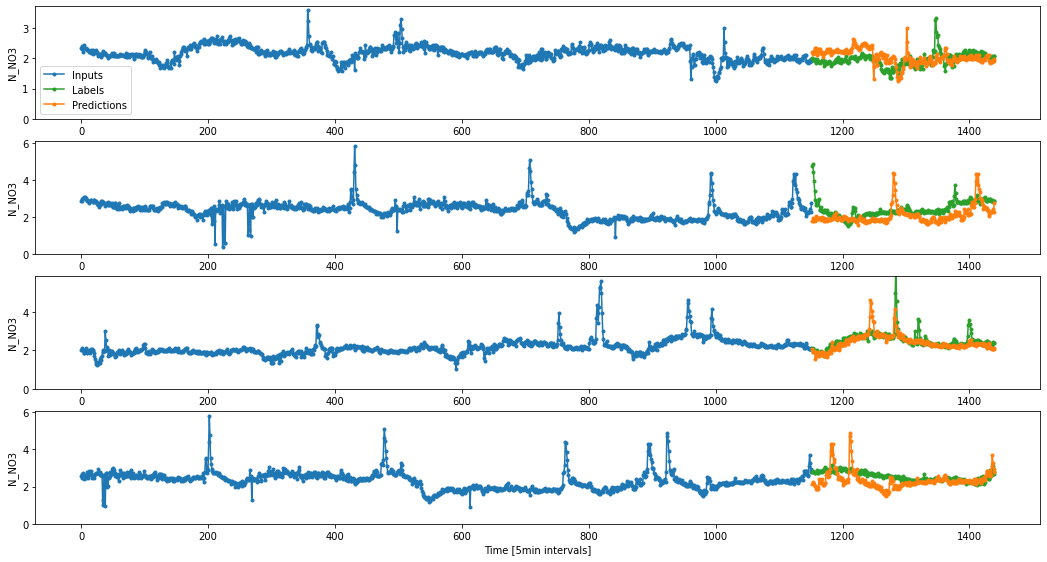

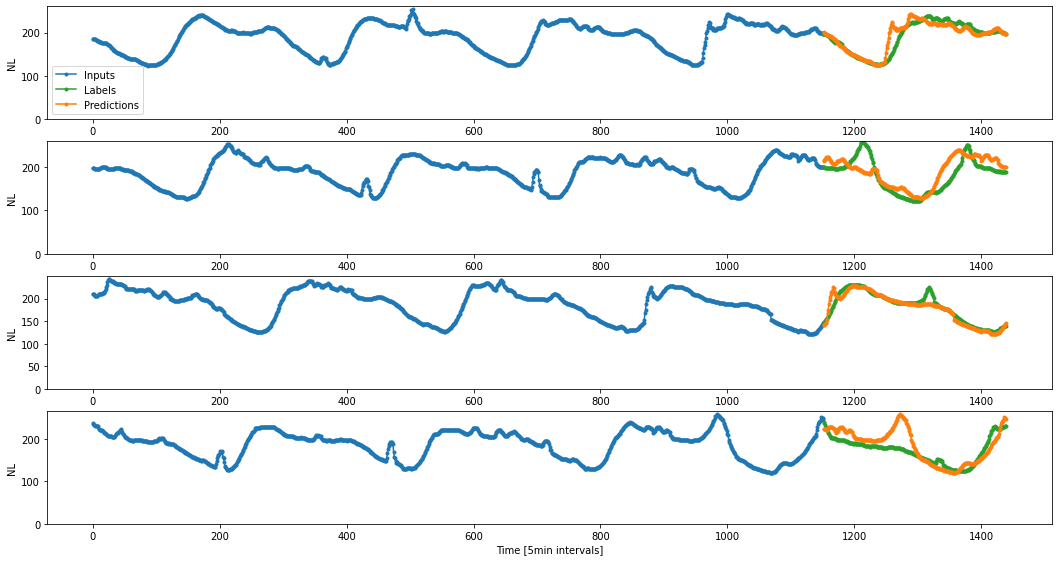

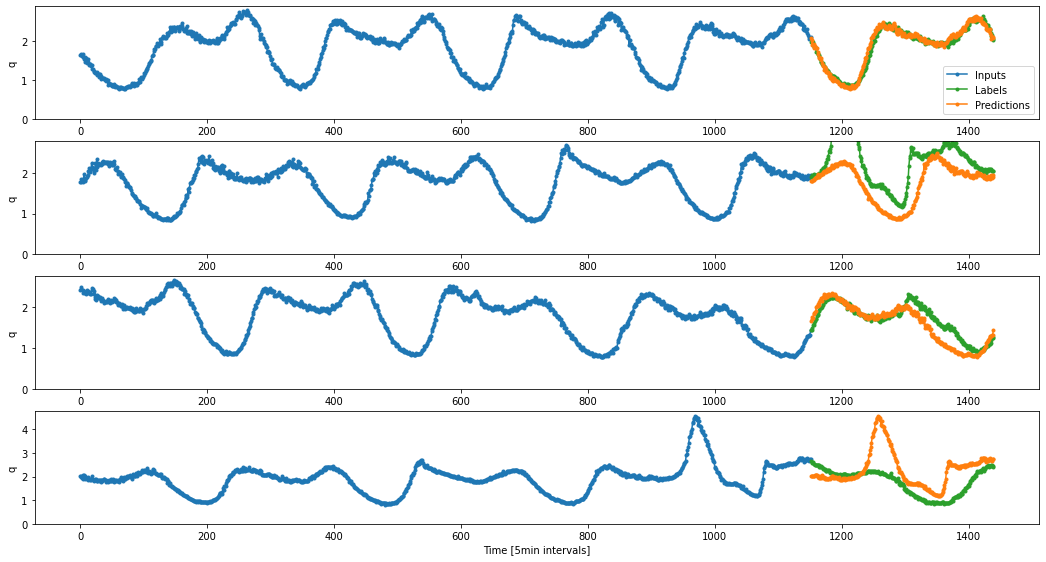

In [223]:
window.plot(repeat_baseline, plotCol='CHSK')
window.plot(repeat_baseline, plotCol='N_NO3')
window.plot(repeat_baseline, plotCol='NL')
window.plot(repeat_baseline, plotCol='q')

##Linear

In [224]:
linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*numOfOutFeatures,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, numOfOutFeatures])
])

print("Training:")
history = compile_and_fit(linear_model, window)

print("Evaluating:")
val_performance['Linear'] = linear_model.evaluate(window.val)
performance['Linear'] = linear_model.evaluate(window.test, verbose=0)

Training:
1413/1413 [==============================] - 29s 20ms/step - loss: 0.6702 - mean_absolute_error: 0.5401 - val_loss: 0.7463 - val_mean_absolute_error: 0.5603
Evaluating:
167/167 [==============================] - 3s 17ms/step - loss: 0.7463 - mean_absolute_error: 0.5603


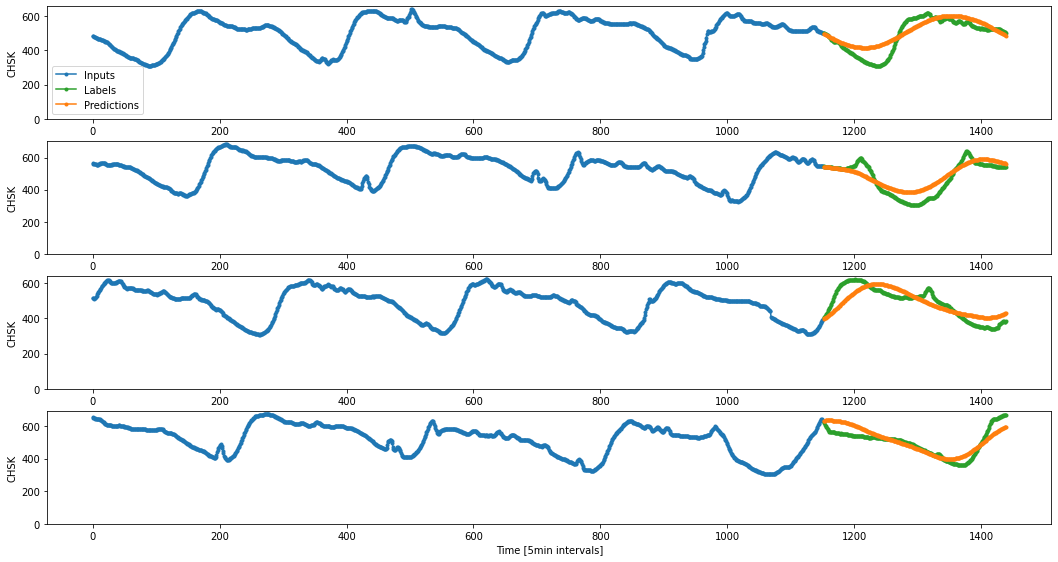

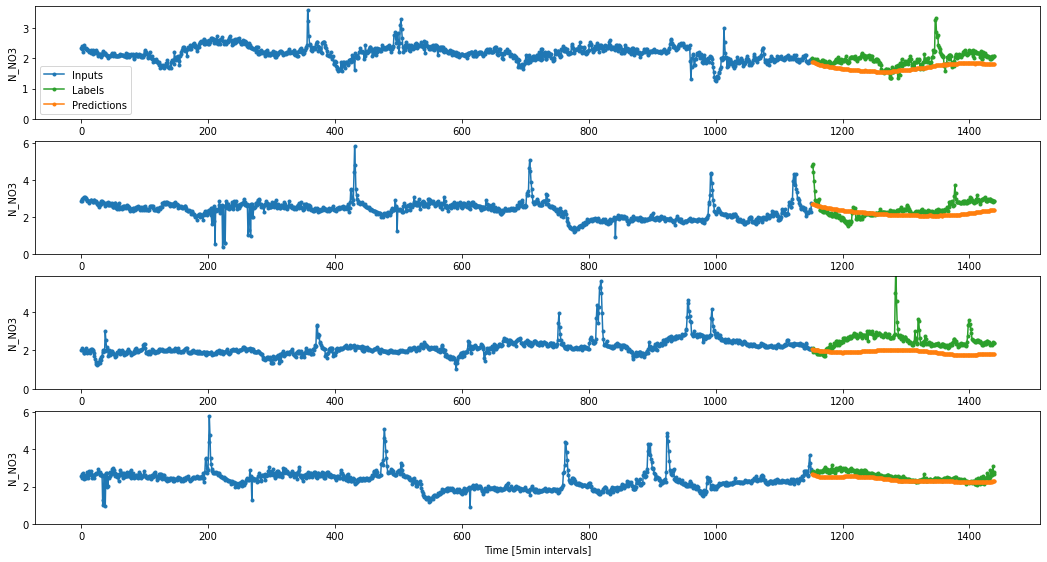

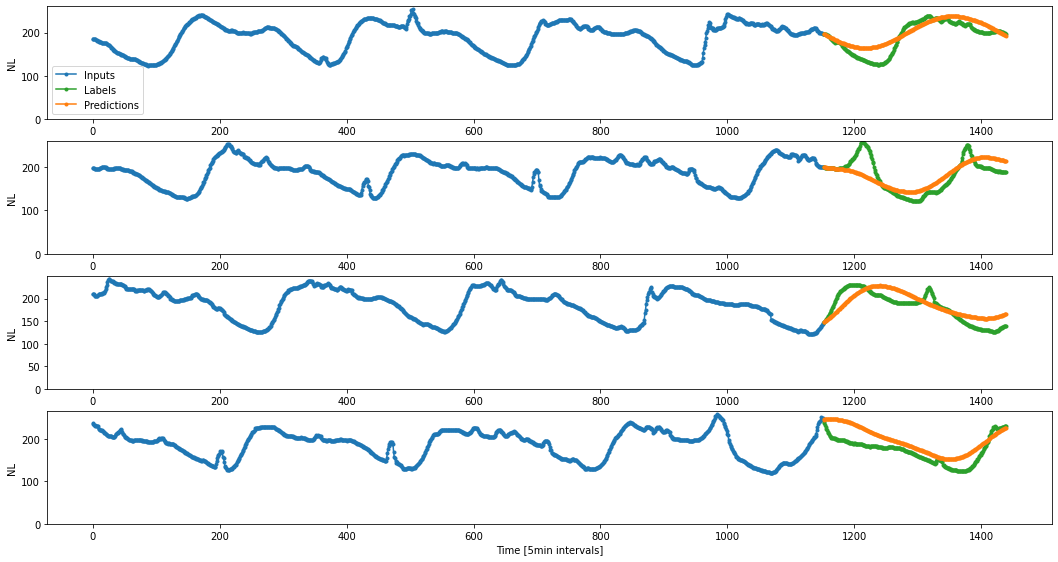

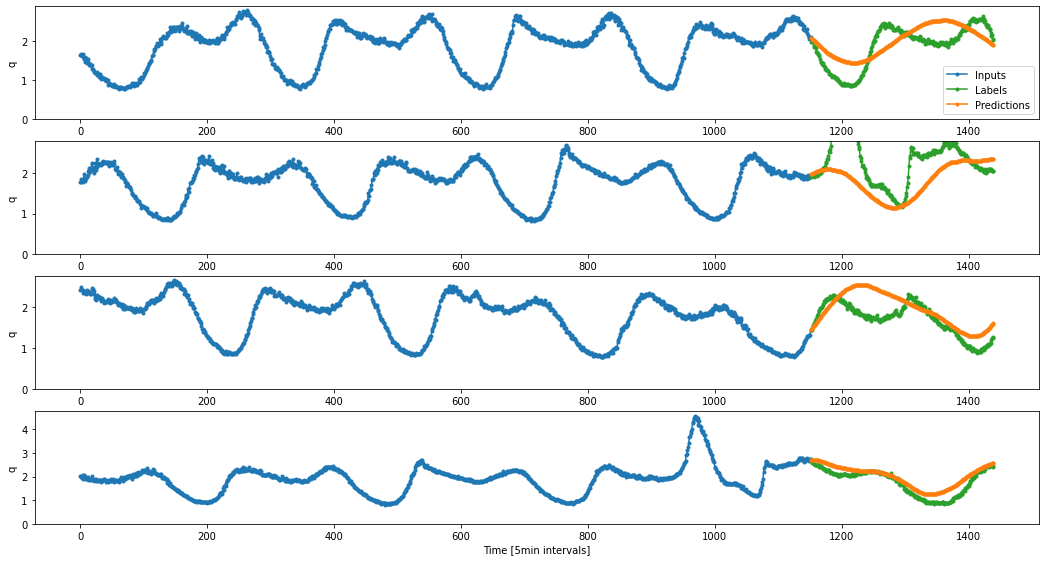

In [225]:
window.plot(linear_model, plotCol='CHSK')
window.plot(linear_model, plotCol='N_NO3')
window.plot(linear_model, plotCol='NL')
window.plot(linear_model, plotCol='q')

##Dense


In [226]:
dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*numOfOutFeatures,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, numOfOutFeatures])
])

print("Training:")
history = compile_and_fit(dense_model, window)

print("Evaluating:")
val_performance['Dense'] = dense_model.evaluate(window.val)
performance['Dense'] = dense_model.evaluate(window.test, verbose=0)

Training:
1413/1413 [==============================] - 29s 21ms/step - loss: 0.4651 - mean_absolute_error: 0.3857 - val_loss: 0.6103 - val_mean_absolute_error: 0.4521
Evaluating:
167/167 [==============================] - 3s 18ms/step - loss: 0.6103 - mean_absolute_error: 0.4521


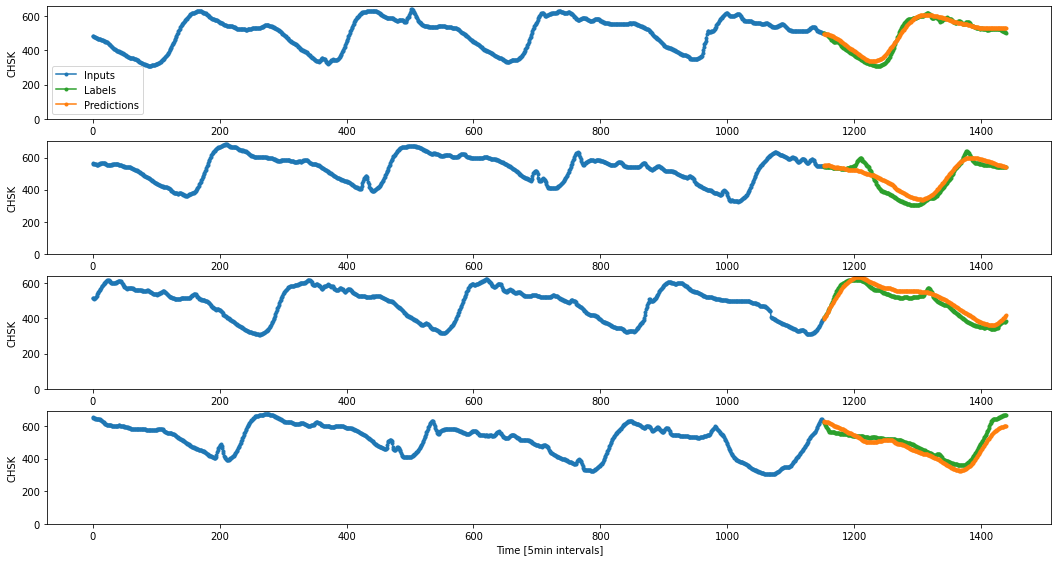

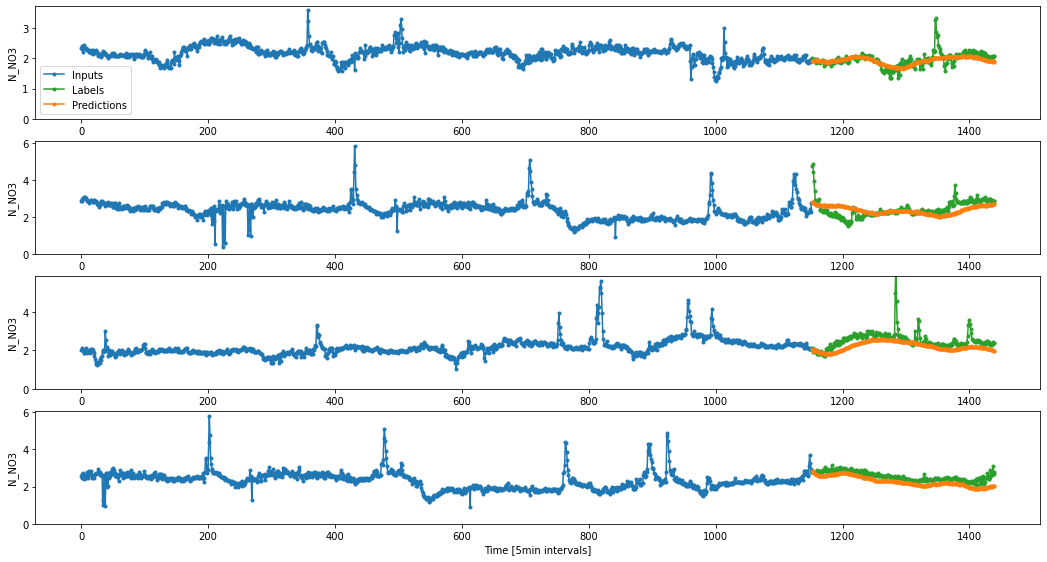

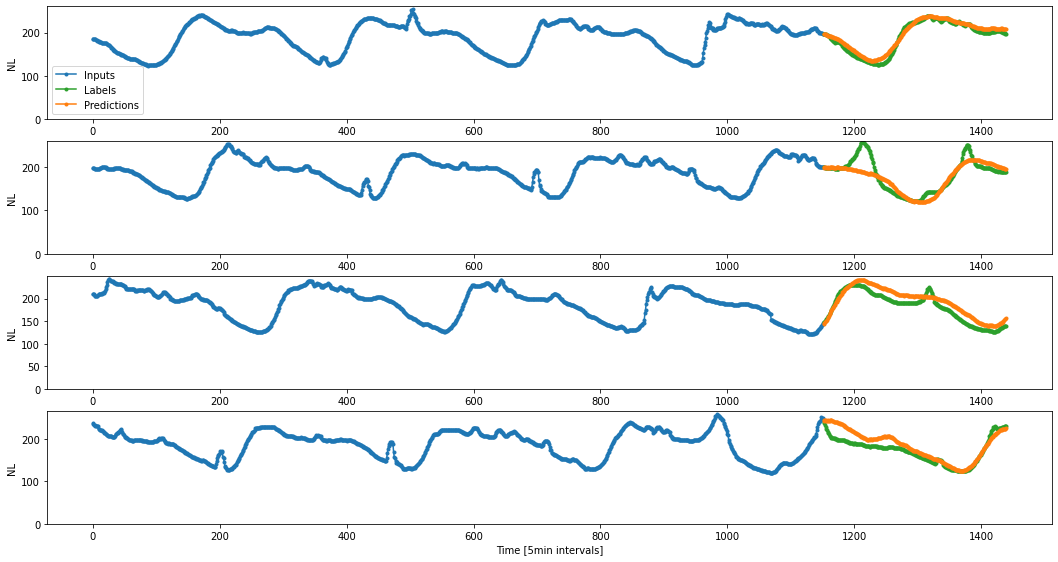

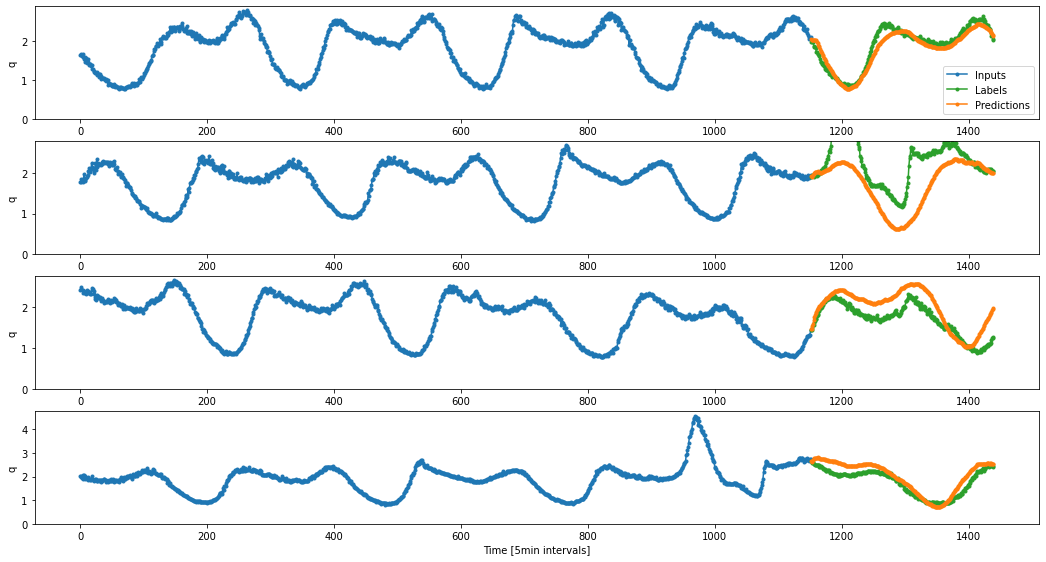

In [227]:
window.plot(dense_model, plotCol='CHSK')
window.plot(dense_model, plotCol='N_NO3')
window.plot(dense_model, plotCol='NL')
window.plot(dense_model, plotCol='q')

## CNN

In [228]:
CONV_WIDTH = 3
conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*numOfOutFeatures,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, numOfOutFeatures])
])

print("Training:")
history = compile_and_fit(conv_model, window)

print("Evaluating:")
val_performance['Conv'] = conv_model.evaluate(window.val)
performance['Conv'] = conv_model.evaluate(window.test, verbose=0)

Training:
1413/1413 [==============================] - 30s 21ms/step - loss: 0.4672 - mean_absolute_error: 0.3854 - val_loss: 0.6420 - val_mean_absolute_error: 0.4718
Evaluating:
167/167 [==============================] - 3s 17ms/step - loss: 0.6420 - mean_absolute_error: 0.4718


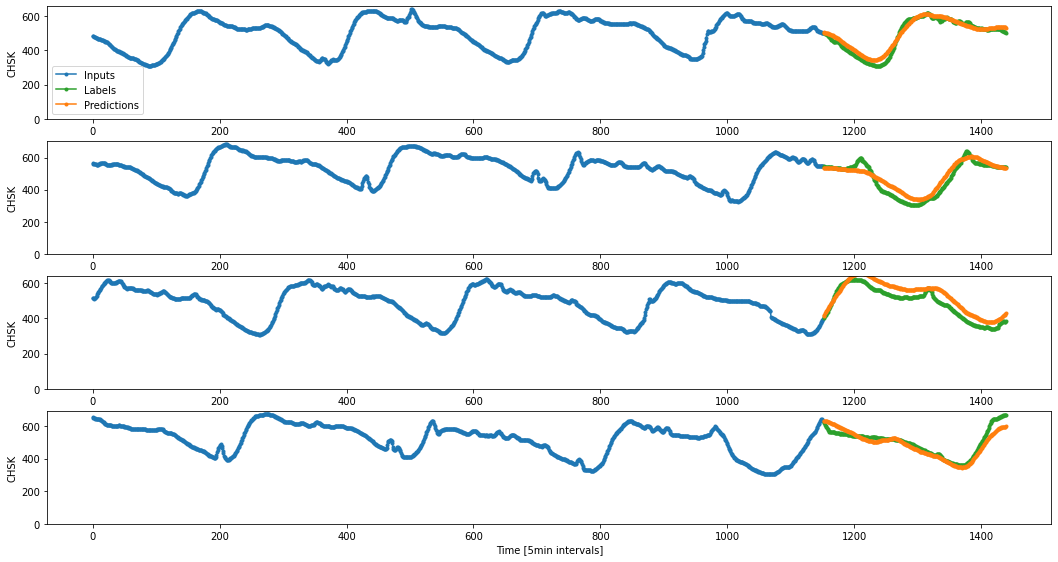

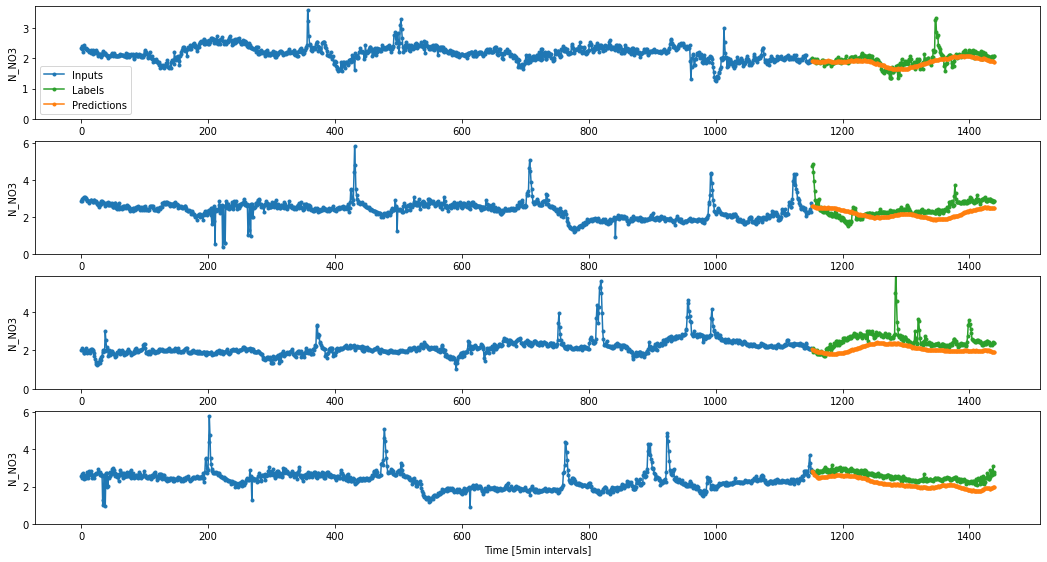

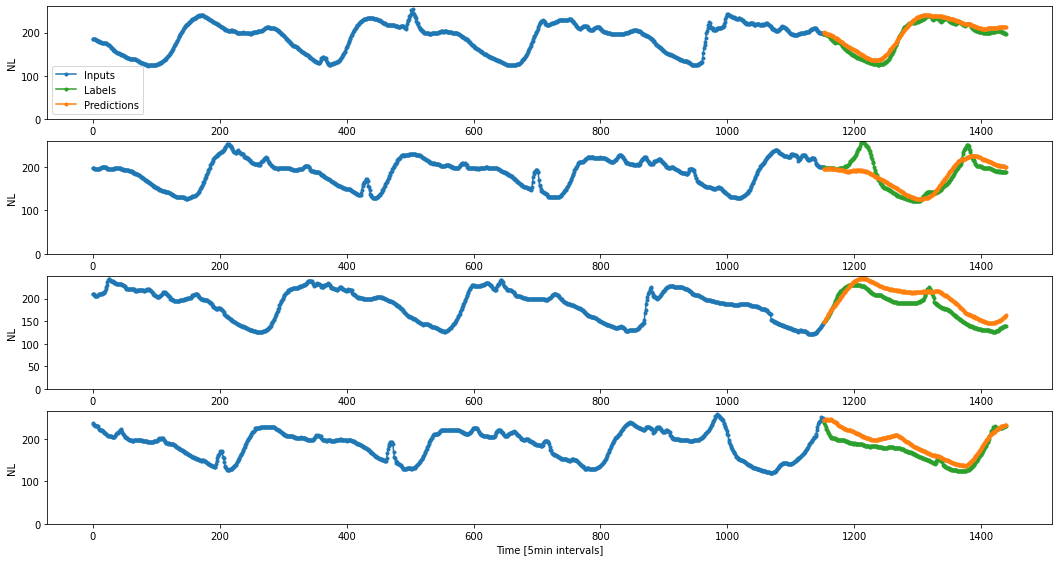

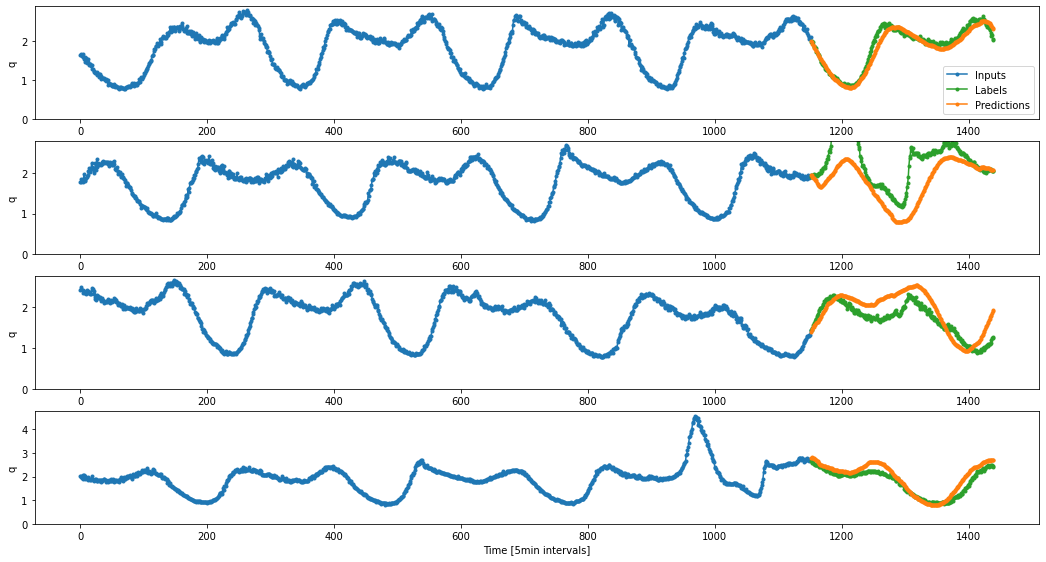

In [229]:
window.plot(conv_model, plotCol='CHSK')
window.plot(conv_model, plotCol='N_NO3')
window.plot(conv_model, plotCol='NL')
window.plot(conv_model, plotCol='q')

##RNN

In [230]:
lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*numOfOutFeatures,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, numOfOutFeatures])
])

print("Training:")
history = compile_and_fit(lstm_model, window)

print("Evaluating:")
val_performance['LSTM'] = lstm_model.evaluate(window.val)
performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0)

Training:
1413/1413 [==============================] - 94s 66ms/step - loss: 0.5301 - mean_absolute_error: 0.4236 - val_loss: 0.6486 - val_mean_absolute_error: 0.4896
Evaluating:
167/167 [==============================] - 6s 35ms/step - loss: 0.6486 - mean_absolute_error: 0.4896


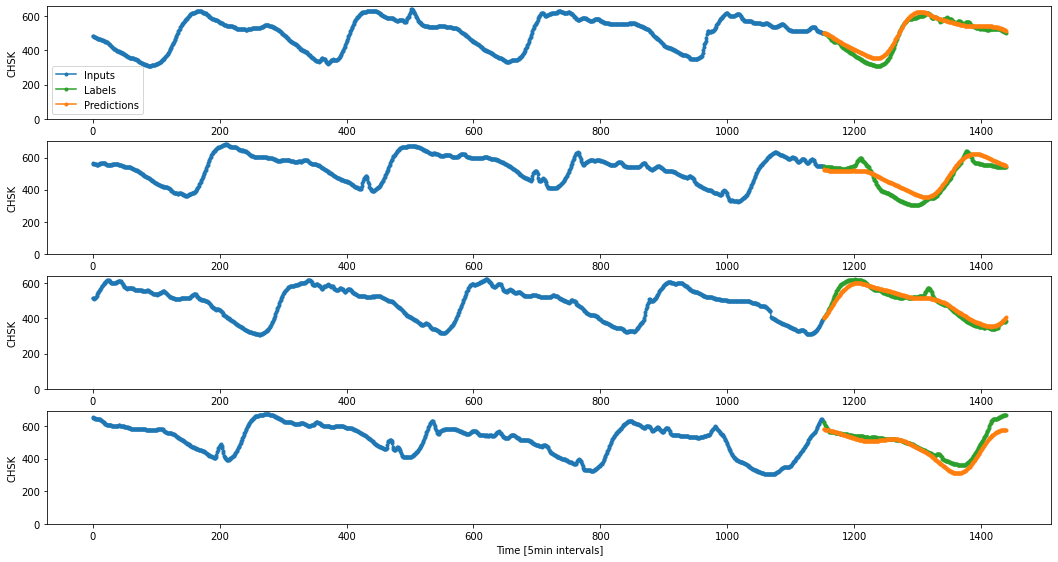

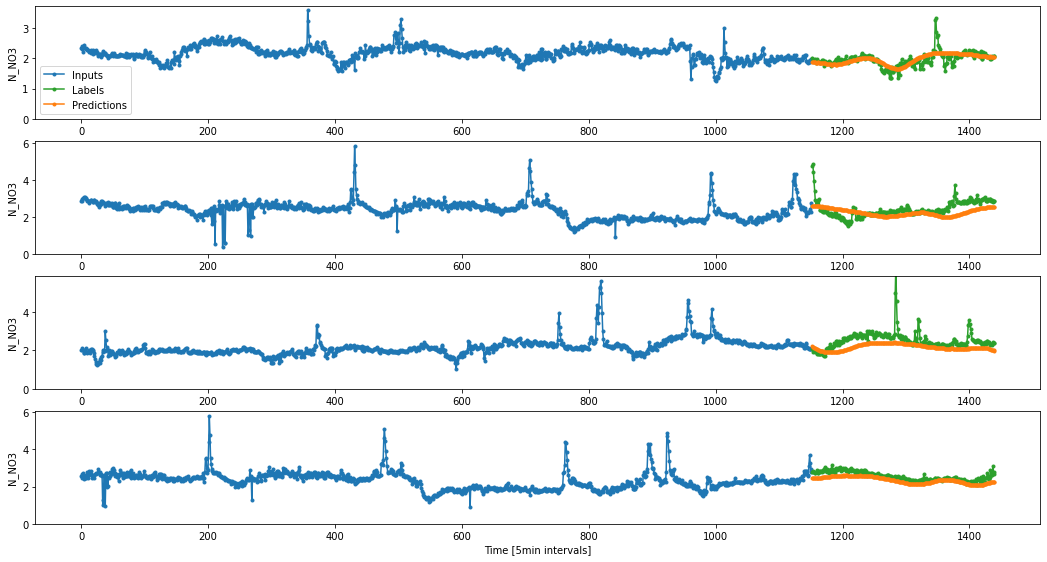

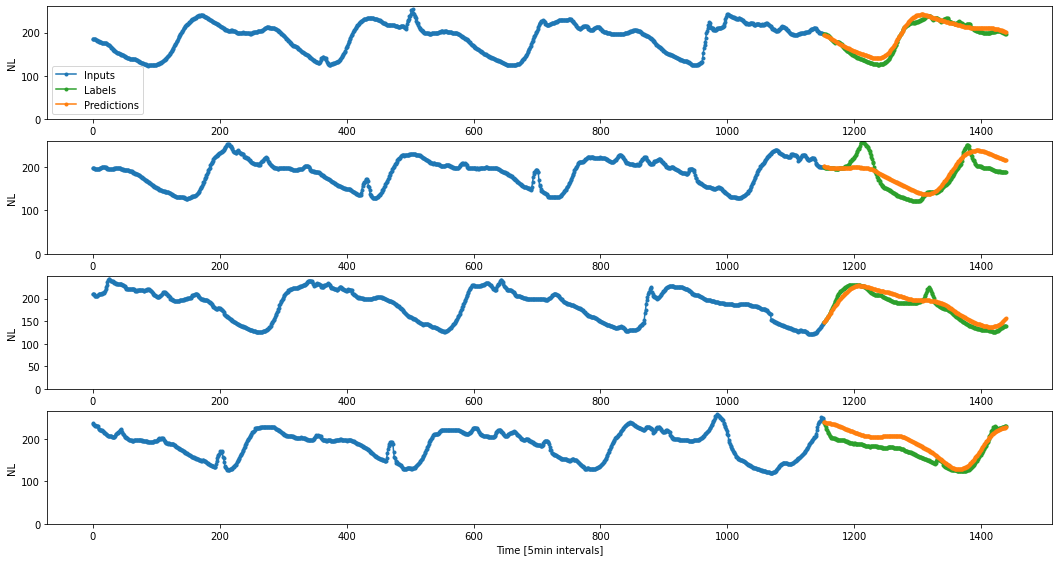

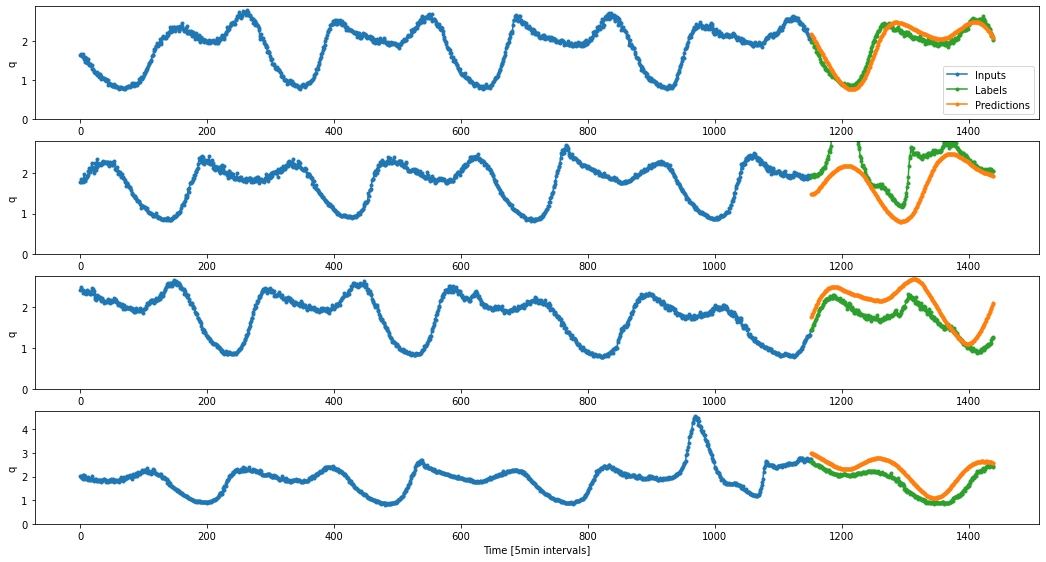

In [231]:
window.plot(lstm_model, plotCol='CHSK')
window.plot(lstm_model, plotCol='N_NO3')
window.plot(lstm_model, plotCol='NL')
window.plot(lstm_model, plotCol='q')

##Dense2

In [232]:
dense_model2 = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.Dense(200, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*numOfOutFeatures,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, numOfOutFeatures])
])

print("Training:")
history = compile_and_fit(dense_model2, window)

print("Evaluating:")
val_performance['Dense2'] = dense_model2.evaluate(window.val)
performance['Dense2'] = dense_model2.evaluate(window.test, verbose=0)

Training:
1413/1413 [==============================] - 30s 21ms/step - loss: 0.4721 - mean_absolute_error: 0.3909 - val_loss: 0.6191 - val_mean_absolute_error: 0.4596
Evaluating:
167/167 [==============================] - 3s 17ms/step - loss: 0.6191 - mean_absolute_error: 0.4596


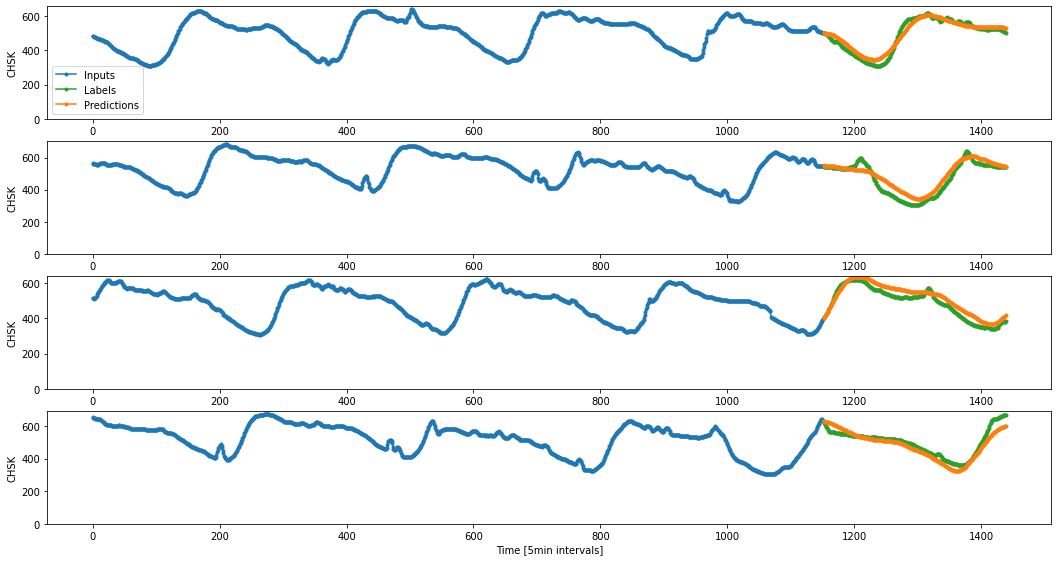

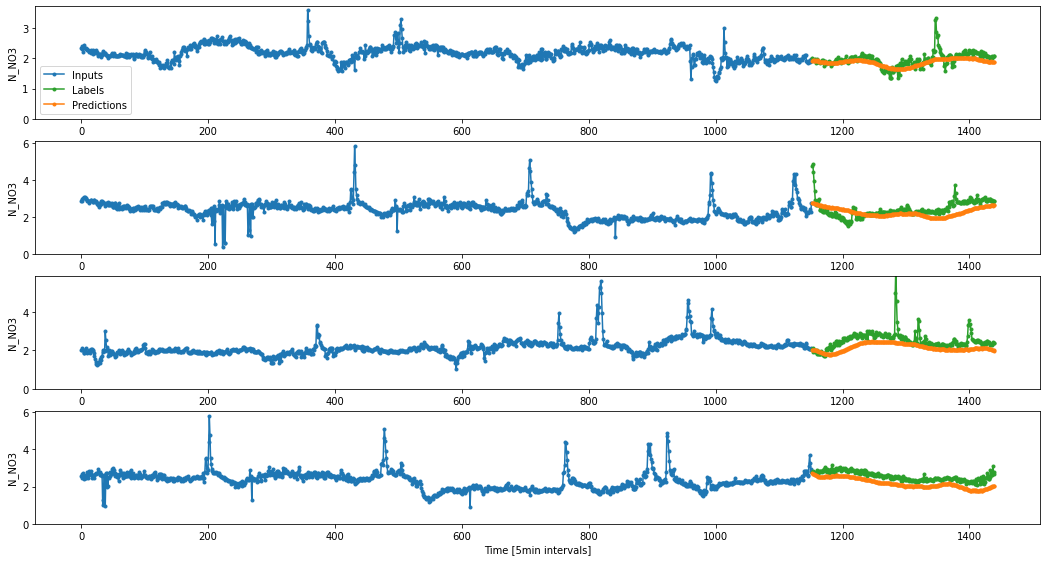

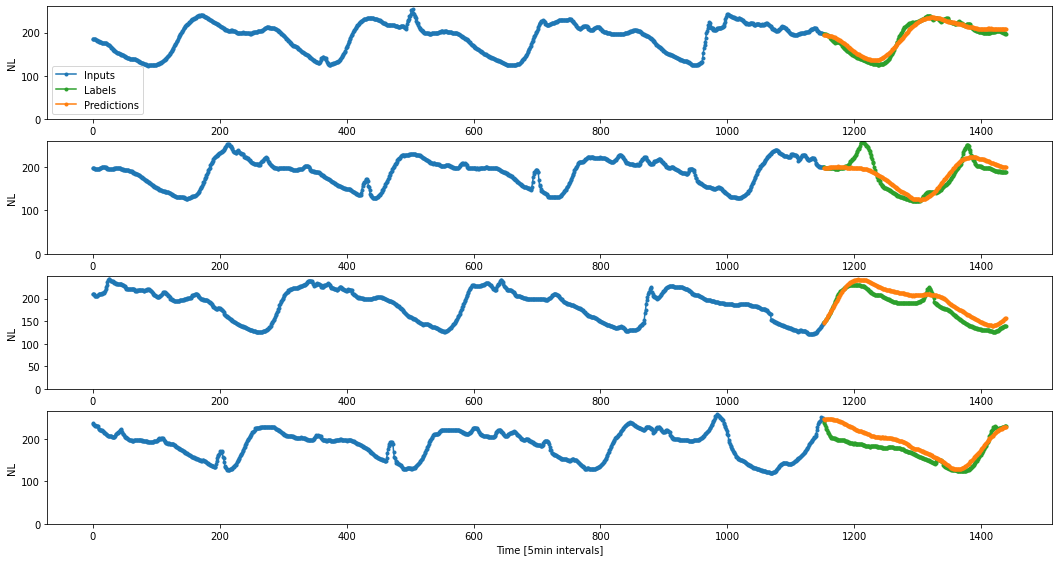

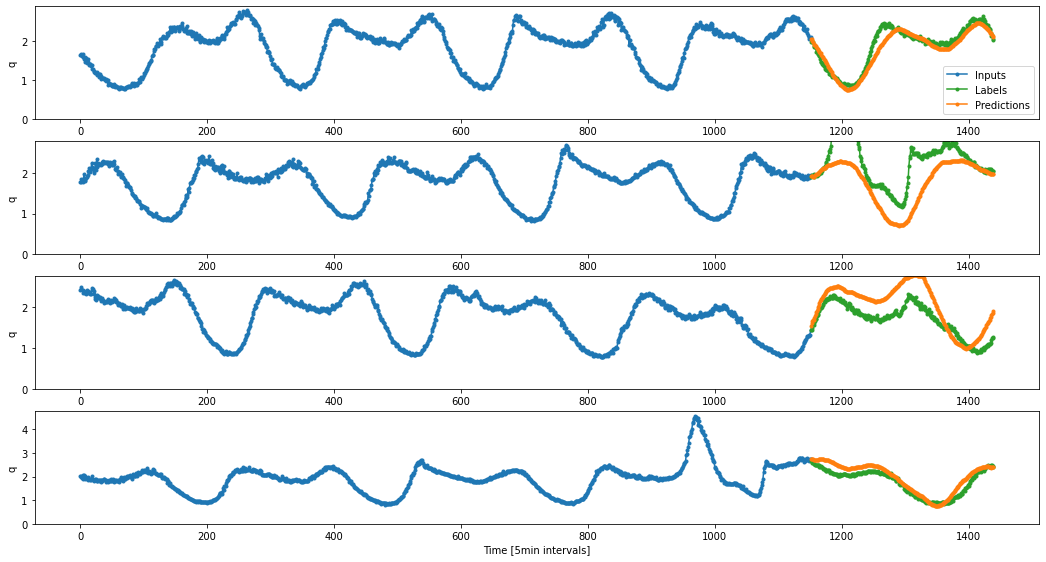

In [233]:
window.plot(dense_model2, plotCol='CHSK')
window.plot(dense_model2, plotCol='N_NO3')
window.plot(dense_model2, plotCol='NL')
window.plot(dense_model2, plotCol='q')

#Performance

[]

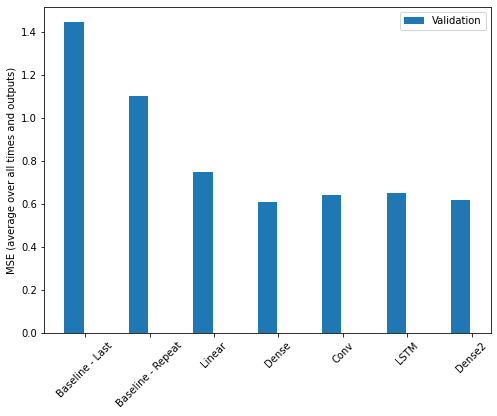

In [252]:
x = np.arange(len(performance))
width = 0.3

metric_index = dense_model.metrics_names.index('loss')
val_mse = [v[metric_index] for v in val_performance.values()]
test_mse = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel(f'MSE (average over all times and outputs)')
_ = plt.legend()
plt.plot()

[]

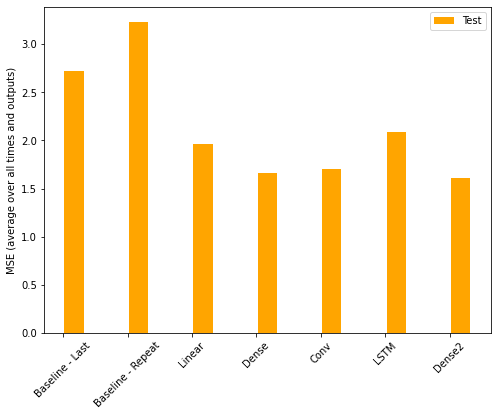

In [253]:
plt.bar(x + 0.17, test_mse, width, label='Test', color='orange')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel(f'MSE (average over all times and outputs)')
_ = plt.legend()
plt.plot()

In [239]:
print("Test:")
for name, value in performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

print('\nVal:')
for name, value in val_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Test:
Baseline - Last: 2.7193
Baseline - Repeat: 3.2260
Linear  : 1.9572
Dense   : 1.6648
Conv    : 1.7006
LSTM    : 2.0883
Dense2  : 1.6081

Val:
Baseline - Last: 1.4447
Baseline - Repeat: 1.1000
Linear  : 0.7463
Dense   : 0.6103
Conv    : 0.6420
LSTM    : 0.6486
Dense2  : 0.6191


normal lr, 2 epochs, 4 variables<br>
Last    : 0.7788<br>
Linear  : 0.3565<br>
Dense   : 0.3262<br>
Conv    : 0.3224<br>
LSTM    : 0.3509<br>
Conv2   : 0.3334<br>

only chsk
Last    : 1.4402<br>
Linear  : 0.8191<br>
Dense   : 0.7121<br>
Conv    : 0.7176<br>
LSTM    : 0.6977<br>
Conv2   : 0.6604<br>

------------------------
Temperature and ph as input<br>
Val:<br>
Baseline - Last: 0.8146<br>
Baseline - Repeat: 0.5558<br>
Linear  : 0.5666<br>
Dense   : 0.4587<br>
Conv    : 0.4488<br>
LSTM    : 0.4859<br>
Dense2  : 0.4699<br>

Q only<br>
Val:<br>
Baseline - Last: 1.1596<br>
Baseline - Repeat: 0.9567<br>
Linear  : 0.5168<br>
Dense   : 0.4344<br>
Conv    : 0.4398<br>
LSTM    : 0.4583<br>
Dense2  : 0.4451<br>

CHSK only<br>
Val:<br>
Baseline - Last: 0.9566<br>
Baseline - Repeat: 0.5521<br>
Linear  : 0.6232<br>
Dense   : 0.4449<br>
Conv    : 0.4782<br>
LSTM    : 0.4418<br>
Dense2  : 0.4526<br>

N_NO3 only<br>
Val:<br>
Baseline - Last: 1.2558<br>
Baseline - Repeat: 1.3146<br>
Linear  : 0.5972<br>
Dense   : 0.5528<br>
Conv    : 0.5141<br>
LSTM    : 0.6354<br>
Dense2  : 0.5422<br>

NL only<br>
Val:<br>
Baseline - Last: 1.1739<br>
Baseline - Repeat: 0.8759<br>
Linear  : 0.5210<br>
Dense   : 0.4466<br>
Conv    : 0.4083<br>
LSTM    : 0.4047<br>
Dense2  : 0.4087<br>